In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler, StandardScaler

from triple_barrier import triple_barrier as tb
import ta
import getTA

In [2]:
import yfinance as yf
df = yf.download('SPY','2001-01-01','2021-5-1')

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,132.000000,132.156250,127.562500,128.812500,87.554405,8737500
2001-01-03,128.312500,136.000000,127.656250,135.000000,91.760071,19431600
2001-01-04,134.937500,135.468750,133.000000,133.546875,90.772385,9219000
2001-01-05,133.468750,133.625000,129.187500,129.187500,87.809311,12911400
2001-01-08,129.875000,130.187500,127.687500,130.187500,88.488998,6625300
...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900


In [5]:
close = pd.to_numeric(df.Close)

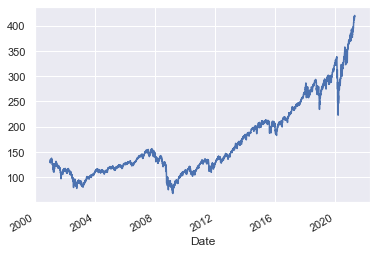

In [6]:
close.plot()

- Sharpe Ratio: $\frac{\mu}{\sigma} = \frac{p\pi+(1-p)(-\pi)}{\sqrt{2\pi p(1-p)}} = \frac{p -0.5}{\sqrt{p(1-p)}}$ 
- $p$ (probability of winning) is given by first model

Triple-Barrier

- why did I choose triple-barrier trading method?
    - I can fix profit and loss symmetrically

In [60]:
f_window = 20
s_window = 60

fema = ta.trend.ema_indicator(close,f_window)
sema = ta.trend.ema_indicator(close,s_window)

diffema = fema-sema
diffema = np.sign(diffema.diff()).dropna()
where = (diffema == 1)

In [62]:
enter = diffema[where].index

In [63]:
enter

DatetimeIndex(['2001-03-30', '2001-04-05', '2001-04-06', '2001-04-09',
               '2001-04-10', '2001-04-11', '2001-04-12', '2001-04-16',
               '2001-04-17', '2001-04-18',
               ...
               '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
               '2021-04-21', '2021-04-23', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='Date', length=2773, freq=None)

In [64]:
pt_sl = [0.05,0.05]

$\pi=0.05$

In [65]:
max_holding = [360,0]

barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

In [66]:
barrier

,exit,price,ret,side
Date,,,,
2001-03-30,2001-04-03,116.690002,-0.055501,1.0
2001-04-05,2001-04-18,115.050003,0.074915,1.0
2001-04-06,2001-04-17,113.300003,0.051267,1.0
2001-04-09,2001-04-18,114.559998,0.079183,1.0
2001-04-10,2001-04-18,116.650002,0.061104,1.0
...,...,...,...,...
2021-04-23,NaT,416.739990,0.000000,1.0
2021-04-26,NaT,417.609985,0.000000,1.0
2021-04-27,NaT,417.519989,0.000000,1.0


**we will see -1000(test periods) only**

In [67]:
returns = barrier.ret
returns = returns[returns!=0]

In [68]:
returns.describe()

count    2755.000000
mean        0.009034
std         0.055761
min        -0.108301
25%        -0.055795
50%         0.049545
75%         0.052078
max         0.079183
Name: ret, dtype: float64

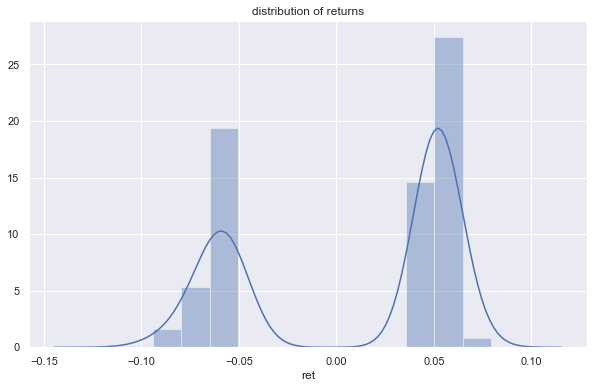

In [69]:
plt.figure(figsize=(10,6))
seaborn.distplot(returns)
plt.title('distribution of returns')
plt.show()

In [70]:
y_ = np.sign(returns).rename('pnl')
y_test = y_.iloc[-1000:]
y_test.value_counts()
#profit and loss

 1.0    673
-1.0    327
Name: pnl, dtype: int64

In [71]:
p = y_test.value_counts().iloc[0]/(y_test.value_counts().iloc[0]+y_test.value_counts().iloc[1])
print('Probabilities of winning (p): ',p)

Probabilities of winning (p):  0.673


In [72]:
asr = np.sqrt(len(y_test))*(p-0.5)/np.sqrt(p*(1-p))
print('Total Sharpe Ratio: ',asr)

Total Sharpe Ratio:  11.661775985836027


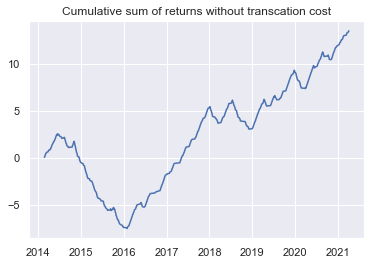

In [73]:
plt.plot(returns.loc[y_test.index].cumsum())
plt.title('Cumulative sum of returns without transcation cost')
plt.show()

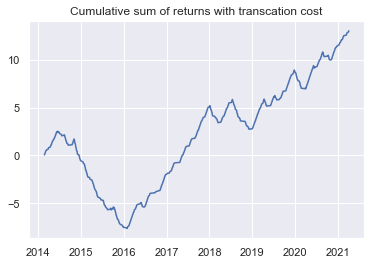

In [74]:
plt.plot((returns.loc[y_test.index]-0.0005).cumsum())
plt.title('Cumulative sum of returns with transcation cost')
plt.show()

# Improve Sharpe ratio by meta-labeling

- drop loss-predicted bets
- prediction by Machine Learning method (Random Forest Classifier)

- NEED precision score > probability of winning of 1st model

### X
- 21 technical indicators features

In [75]:
df_ = df.drop(columns='Adj Close').iloc[:,:5]
list= []
for i in df_.columns:
    list.append(i.lower())
df_.columns = list

In [76]:
TI = getTA.get_ta(df_).shift(1).iloc[:,4:].dropna()

In [77]:
TI

,volume,m_rsi,m_roc,m_cmo,m_wr,vm_cmf,vm_mfi,vm_fi,vm_eom,vl_bbp,vl_atr,t_macdd,t_trix,t_cci,t_dpo,t_kst,t_adx
Date,,,,,,,,,,,,,,,,,
2001-03-07,6917000.0,41.391823,-5.444724,-29.199,-63.211553,0.095492,34.446373,-3.013060e+06,75.965110,0.318648,2.687741,-0.379747,-0.237680,-44.611162,1.486495,-65.232018,28.790793
2001-03-08,6371700.0,44.381002,-2.622692,-31.642,-55.564983,0.153108,39.142589,-1.763403e+06,-4.419486,0.395773,2.587188,-0.140437,-0.242901,-36.267458,-0.103000,-58.831159,27.840948
2001-03-09,6055000.0,44.852185,-0.989171,-18.959,-43.710623,0.171833,39.078487,-1.390389e+06,5.268313,0.425713,2.480960,0.043718,-0.243344,-26.416494,-2.494497,-59.023624,26.859360
2001-03-12,10020300.0,36.025085,-1.799078,-26.404,-82.854092,0.155874,38.276230,-6.574097e+06,-62.215131,0.176043,2.590178,-0.065339,-0.245665,-78.338804,-1.816502,-60.068923,26.957551
2001-03-13,13972900.0,27.762391,-6.144182,-34.972,-97.024329,0.115593,36.565477,-1.617450e+07,-152.294784,-0.091118,2.805879,-0.449314,-0.256557,-177.599689,-1.978501,-65.493150,28.272159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,73209200.0,65.331900,2.496371,34.017,-11.751043,0.352810,66.356066,4.455038e+07,11.671894,0.787002,4.294857,-0.003883,0.221666,83.882256,0.317491,57.451246,26.764451
2021-04-27,52182400.0,66.157157,2.225104,34.851,-5.000119,0.306349,66.061565,4.467153e+07,5.390611,0.791206,4.093797,-0.013682,0.222043,95.171789,2.205994,57.394081,27.169416
2021-04-28,51303100.0,65.982181,1.465406,30.222,-6.448856,0.291899,60.431944,3.763030e+07,-1.058035,0.768876,3.932813,-0.079692,0.221616,89.409794,1.269019,57.111906,27.340116


In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
TI_norm = pd.DataFrame(scaler.fit_transform(TI),index=TI.index)

In [79]:
from sklearn.decomposition import PCA
pca = PCA(10)
TI_pc = pd.DataFrame(pca.fit_transform(TI_norm),index=TI.index)
TI_pc

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2001-03-07,2.367584,2.181919,-1.090865,7.765633,-0.843942,-1.942976,1.761774,1.491960,1.938961,0.761776
2001-03-08,2.223511,1.015815,-0.551355,0.202982,1.579127,0.722457,0.207811,-0.047863,1.439913,-0.662308
2001-03-09,1.442066,1.579748,-1.028288,0.580820,1.141115,0.060624,0.489159,0.629718,1.658573,-0.625392
2001-03-12,3.385641,-0.051327,-0.714954,-5.492880,3.277850,2.270080,-0.557738,-1.207083,1.318685,-1.234258
2001-03-13,5.893709,-1.977193,0.092482,-13.504091,6.275578,5.336043,-2.034963,-2.949314,0.711817,-2.465097
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,-2.672984,-0.364192,1.432463,0.888691,-0.733597,-0.224504,1.760108,-0.560070,0.580852,-0.034405
2021-04-27,-2.583708,-0.622165,1.666321,0.749681,-0.290136,0.440323,1.415278,-0.907911,0.169240,-0.051286
2021-04-28,-2.258344,-0.766231,1.535492,0.107452,-0.059245,0.505898,1.342942,-0.734186,0.095657,-0.493403


In [80]:
tmp = TI_pc.join(y_).dropna()
X = tmp.iloc[:,:-1]
y = tmp.iloc[:,-1]

In [82]:
X_train = X.iloc[:-500]
X_test = X.iloc[-500:]

y_train = y.iloc[:-500]
y_test = y.iloc[-500:]

In [83]:
X_test

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2017-11-27,-2.646481,-0.461953,0.973869,0.649123,0.586661,0.828098,-0.627589,0.348580,0.898492,-0.642879
2017-11-28,-2.143822,-0.366968,0.610178,0.374820,0.488526,0.438269,-0.513961,0.481791,0.622572,-0.752444
2017-11-29,-3.537573,0.203155,1.209635,0.567861,0.270977,0.115426,-0.790329,0.414643,0.619562,-1.174722
2017-11-30,-3.281297,0.140329,1.084472,0.371567,0.563494,0.022701,-0.476494,0.314505,0.603525,-0.789654
2017-12-01,-4.127709,0.630099,1.379931,0.172274,0.456546,-0.521970,-0.492072,0.196556,0.427807,-0.398933
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,-2.008013,1.618094,-0.369188,0.742341,-1.634162,1.868687,0.856774,-1.027159,-0.929141,0.244476
2021-03-26,0.894523,-0.269482,0.139154,-1.606897,-1.203738,1.995887,0.839733,-0.547120,-0.925292,0.078007
2021-03-29,-0.978702,0.840162,0.169128,3.555961,-2.694159,0.989752,1.098939,-0.544245,-0.623151,0.282088


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [85]:
clf = RandomForestClassifier(criterion='entropy')#,class_weight='balanced_subsample')

In [86]:
n_estimators = [500,1000]
max_depth = [2, 5]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth)

gs = GridSearchCV(clf, param_grid = param_grid, scoring ='precision')

In [87]:
gs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': [2, 5], 'n_estimators': [500, 1000]},
             scoring='precision')

In [88]:
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=500)

In [89]:
y_pred = gs.predict(X_test)
y_pred = pd.Series(y_pred, index=X_test.index).rename('y_pred')
y_pred.head()

Date
2017-11-27    1.0
2017-11-28    1.0
2017-11-29    1.0
2017-11-30    1.0
2017-12-01    1.0
Name: y_pred, dtype: float64

In [90]:
from sklearn.metrics import precision_score

In [91]:
p2 = precision_score(y_test,y_pred)
print('Precision score (Probability of winning after drop predicted loss): {}'.format(p2))

Precision score (Probability of winning after drop predicted loss): 0.6907730673316709


In [92]:
# After drop predicted loss
y_2nd = y_test.drop(index=y_pred.loc[y_pred==-1].index)

y_2nd.value_counts()

 1.0    277
-1.0    124
Name: pnl, dtype: int64

In [93]:
p2 = y_2nd.value_counts().iloc[0]/(y_2nd.value_counts().iloc[0]+y_2nd.value_counts().iloc[1])
print('Probabilities of winning (p): ',p2)

Probabilities of winning (p):  0.6907730673316709


In [94]:
asr = np.sqrt(len(y_2nd))*(p2-0.5)/np.sqrt(p2*(1-p2))
print('Total Sharpe Ratio: ',asr)

Total Sharpe Ratio:  8.265761963292833


In [95]:
returns2 = returns.loc[y_2nd.index]

In [96]:
returns2

Date
2017-11-27    0.049443
2017-11-28    0.049176
2017-11-29    0.049785
2017-11-30    0.053628
2017-12-01    0.049643
                ...   
2021-03-16    0.049186
2021-03-17    0.049119
2021-03-26    0.049009
2021-03-30    0.052171
2021-03-31    0.051462
Name: ret, Length: 401, dtype: float64

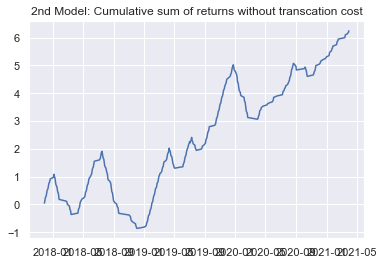

In [97]:
plt.plot((returns2-0.0005).cumsum())
plt.title('2nd Model: Cumulative sum of returns without transcation cost')
plt.show()

Results

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

And,

keep opportunities as many as possible
- n is also important
- let the model do not lose many opportunities
- but how? - further study needed